## Econ 430
### UCLA, Master of Quantitative Economics
#### Dr. Randall R. Rojas

In [1]:
# Note: First make sure to install the following packages
# pip install altair
# pip install pmdarima
# pip install rpy2

There are quite a large number of packages we need to load, however, the most common ones are summarized in  
[S. Pawar's blog](https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/2020/04/21/timeseries-part1.html#Train-Test-Split:), which we now proceed to load. Also, the Python code blocks are adaptations from the same source to our data and analysis. For the seasonal adjustments, please see the [seasonal library paper](https://cran.r-project.org/web/packages/seasonal/vignettes/seas.pdf) and the respective [package](https://cran.r-project.org/web/packages/seasonal/seasonal.pdf) details. 

I recommend reviewing the `statsmodels` packages [tsa](https://www.statsmodels.org/stable/tsa.html), [statespace](https://www.statsmodels.org/stable/statespace.html), and [vector_ar](https://www.statsmodels.org/stable/vector_ar.html).

Lastly, a great online resource (R version) is R.  Hyndman and   G. Athanasopoulos [Forecasting: Principles and Practice 3rd Ed.](https://otexts.com/fpp3/index.html), or you can also access the [2nd Ed.](https://otexts.com/fpp2/).  Hyndman also has a [blog](https://robjhyndman.com/hyndsight/ftsviz/) with cool resources.

In [1]:
import pandas as pd
import numpy as np
import itertools

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
plt.style.use('seaborn-white')
%matplotlib inline

#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
#from nimbusml.timeseries import SsaForecaster
from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")
np.random.seed(123)

## R Version of the Analysis

In [5]:
#library to use R in Python 
# To start the R session in the notebook
import rpy2

import warnings
warnings.filterwarnings('ignore')

from rpy2.robjects import pandas2ri
import rpy2.rinterface as rinterface
pandas2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
# Use to install pagackes, just changing the name of the package
%%R
# install.packages("seasonal")

UsageError: Line magic function `%%R` not found.


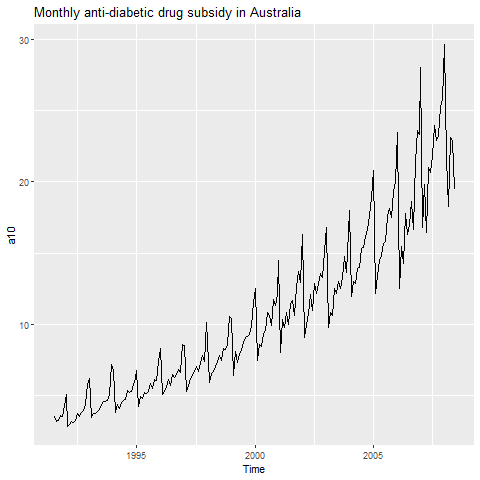

In [6]:
%%R 
# Look  at the data
library(fpp2)
data(a10)
a10 %>%  autoplot() + ggtitle("Monthly anti-diabetic drug subsidy in Australia") +xlab("Time")+ylab("a10")

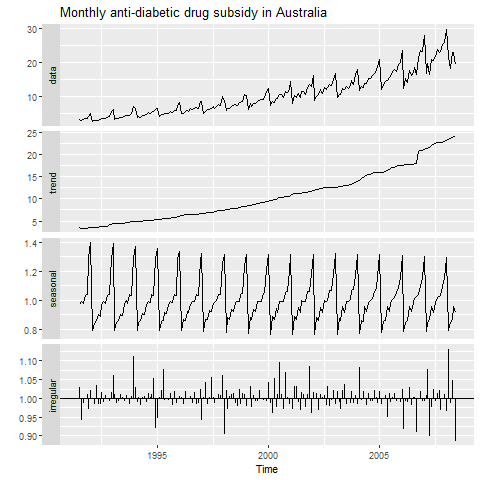

In [7]:
%%R 
# Plot the series components
library(seasonal)
library(fpp2)
data(a10)
# seas with x11 filter
a10 %>% seas(x11="") -> fit
autoplot(fit) +
  ggtitle("Monthly anti-diabetic drug subsidy in Australia")


#m <- seas(a10)
#plot(m, trend = TRUE)

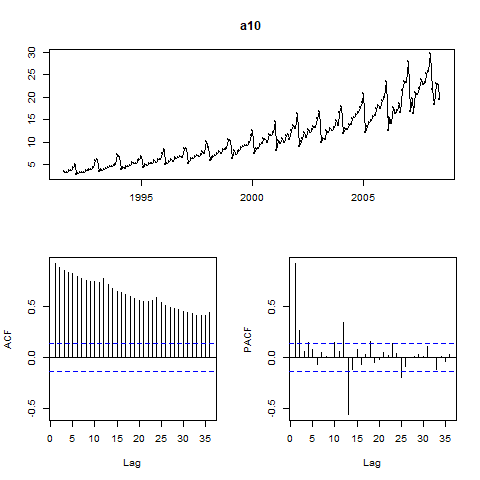

In [8]:
%%R 
# Plot the ACF and PACF
library(forecast)
library(fpp2)
data(a10)

# tsdisplay gives us the original plot w ACF and PACF
tsdisplay(a10)
# Note: You can also plot them separately as shown below after the tsdisplay plot

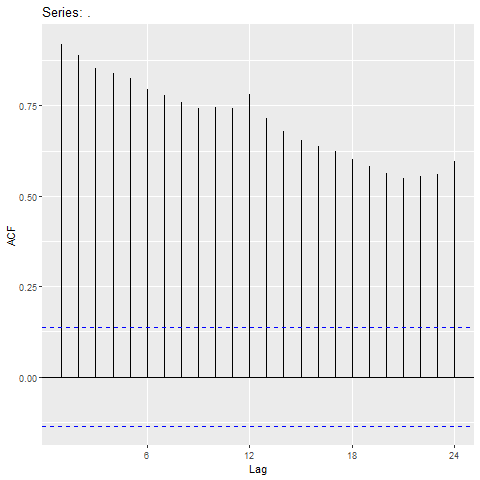

In [13]:
%%R
a10 %>% ggAcf()

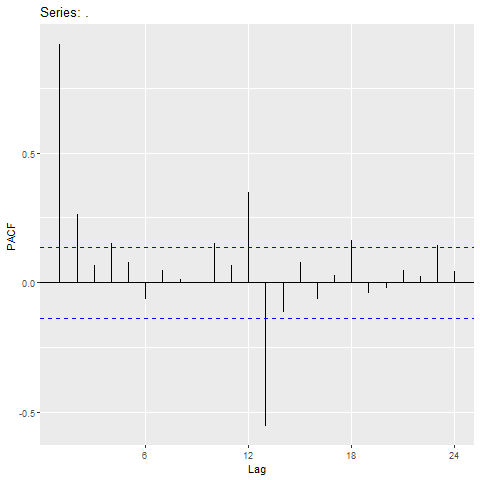

In [14]:
%%R
a10 %>% ggPacf()

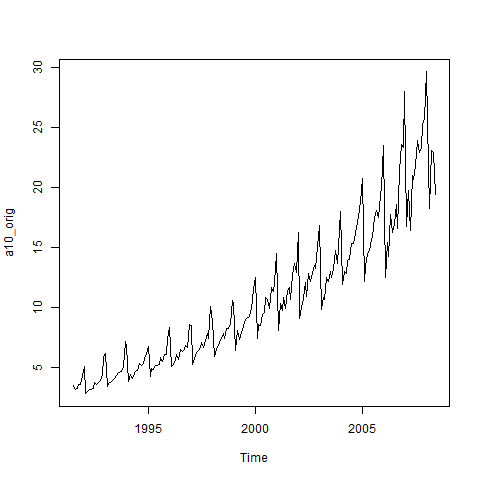

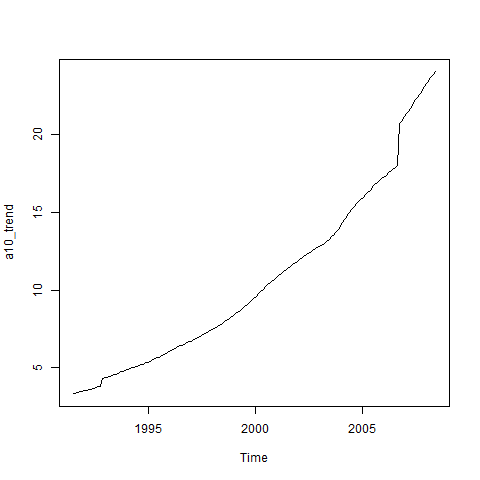

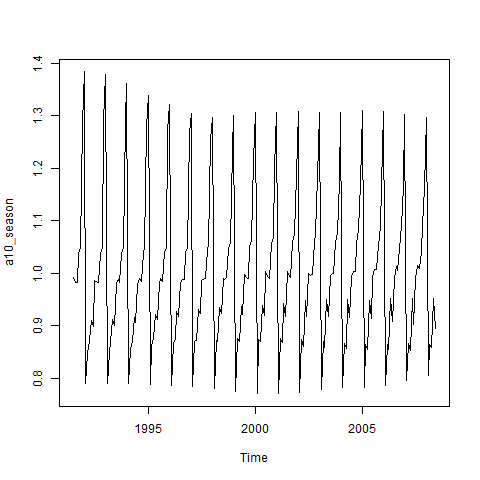

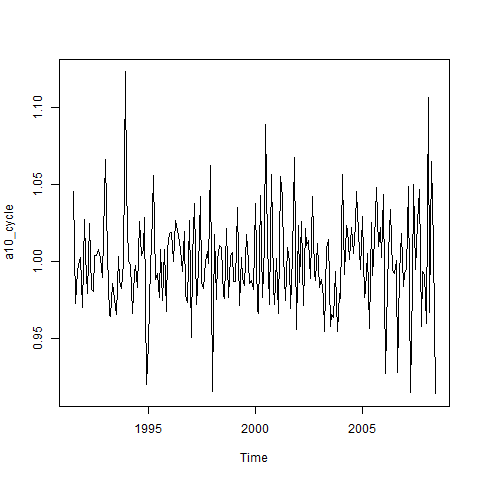

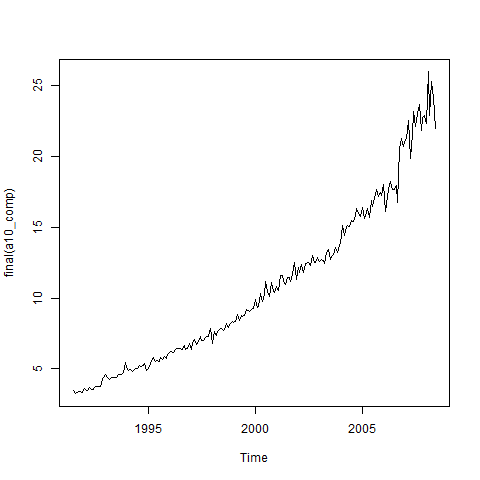

In [15]:
%%R 

library(seasonal)
library(fpp2)
data(a10)

# You can extract the individual components using "seas" to first perform the decomposition, and then get the terms: 

# Extract all components into one object seas(object)
a10_comp = seas(a10)

# 1) Orginal Series
a10_orig = original(a10_comp)
plot(a10_orig)

# 2) Trend
a10_trend<-trend(a10_comp)
plot(a10_trend)

# 3) Seasonality
a10_season<-seasonal(a10_comp)
plot(a10_season)

# 4) Cycles/Irregular
a10_cycle<-irregular(a10_comp)
plot(a10_cycle)

# Seasonally Adjusted (optimal adjustment)
plot(final(a10_comp))


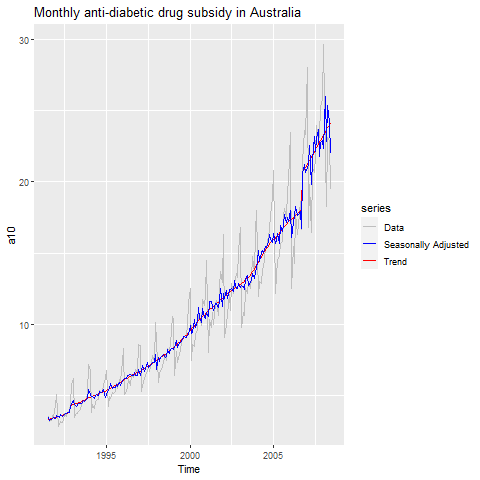

In [16]:
%%R 
# Plot the seasonally adjusted series
library(seasonal)
library(fpp2)
data(a10)
fit = seas(a10)
# Note: the default seasonal adjustment is "seats", but you can set it to the X11 used by the US Census Bureau.
#fit = seas(a10,x11="")
autoplot(a10, series="Data") +
  autolayer(trendcycle(fit), series="Trend") +
  autolayer(seasadj(fit), series="Seasonally Adjusted") +
  xlab("Time") + ylab("a10") +
  ggtitle("Monthly anti-diabetic drug subsidy in Australia") +
  scale_colour_manual(values=c("gray","blue","red"),
             breaks=c("Data","Seasonally Adjusted","Trend"))

In [9]:
%%R 
# Five best fit models to the Irregular component
library(seasonal)
library(fpp2)
data(a10)
a10_comp = seas(a10)
fivebestmdl(a10_comp)

           arima    bic
1 (0 1 1)(0 1 1) -3.142
2 (1 1 1)(0 1 1) -3.116
3 (0 1 2)(0 1 1) -3.116
4 (2 1 1)(0 1 1) -3.089
5 (1 1 2)(0 1 1) -3.087


In [10]:
%%R 
# Plot an ETS forecast of the data
library(forecast)
library(fpp2)
data(a10)
plot(forecast(a10))

## Python Version of the Analysis (not a perfect substitute)

In [13]:
import pandas as pd
data = pd.read_csv('a10.csv',parse_dates=True, index_col="index")
data.head()
data.index.freq='MS'
data.head() 

# Added sanity checks
# data.isna().sum()
# data.index.nunique()
# pd.crosstab(index=data.index, columns=data.index.month)

,value
index,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


Text(0.5, 0.98, 'Additive Decomposition')

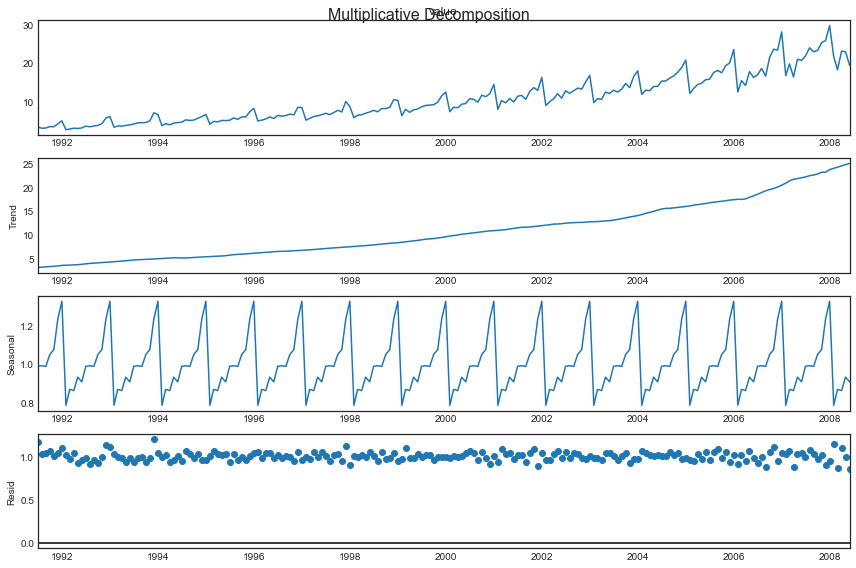

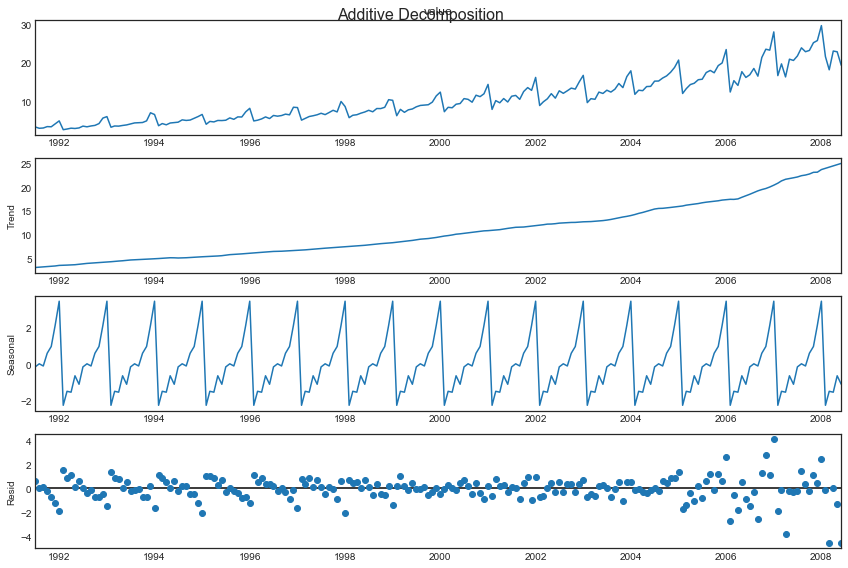

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
plt.style.use('seaborn-white')
%matplotlib inline

# Multiplicative Decomposition
decomposeM = seasonal_decompose(data["value"],model='multiplicative', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
#decomposeM.plot();
decomposeM.plot().suptitle('Multiplicative Decomposition', fontsize=16)


# Additive Decomposition
decomposeA = seasonal_decompose(data["value"],model='additive', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
decomposeA.plot().suptitle('Additive Decomposition', fontsize=16)

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
ljung_p = np.mean(ljung(x=decomposeM.resid.dropna())[1]).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box, p value: 0.009 , Residuals are correlated


Mean is: 10.694429582156861


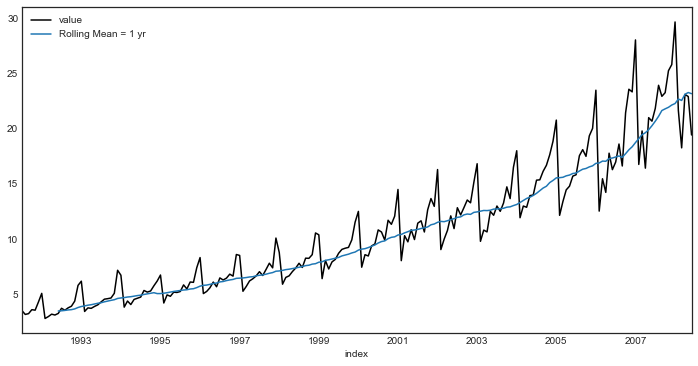

In [16]:
#  Mean Reversion (constant mean?)
data.plot(figsize=(12,6), legend=True, label="a10", cmap='gray')
# Rolling mean
data["value"].rolling(12, center=False).mean().plot(legend=True, label="Rolling Mean = 1 yr");
print("Mean is:", data["value"].mean())

S.D is: 5.956997805897407


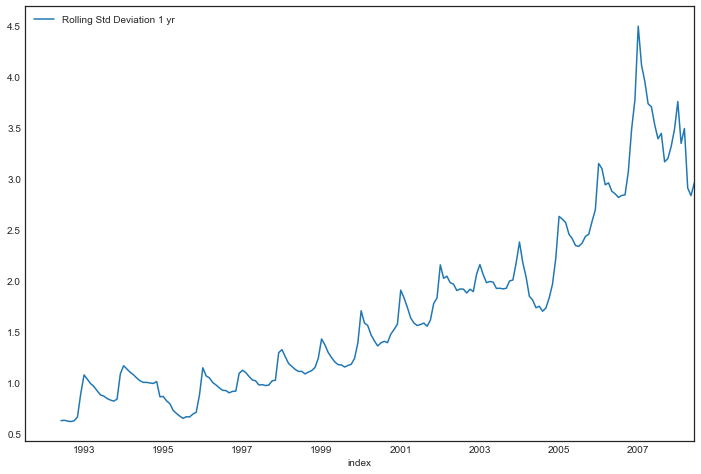

In [17]:
# Constant variance?
data["value"].rolling(12).std().plot(legend=True, label="Rolling Std Deviation 1 yr");
print("S.D is:", data["value"].std())

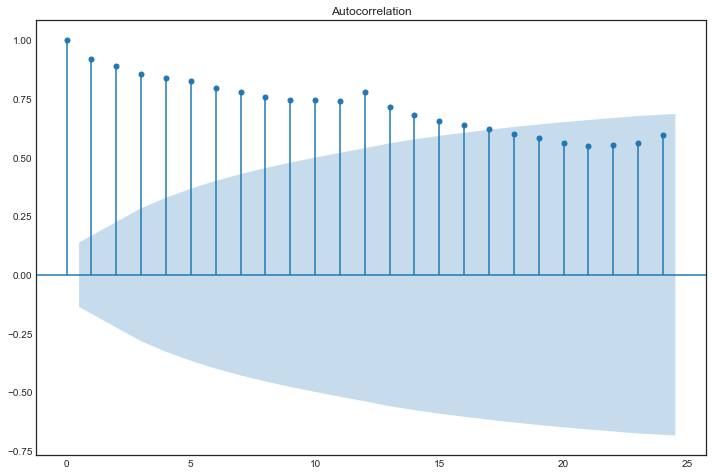

In [18]:
# Plot the ACF
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
plot_acf(data);

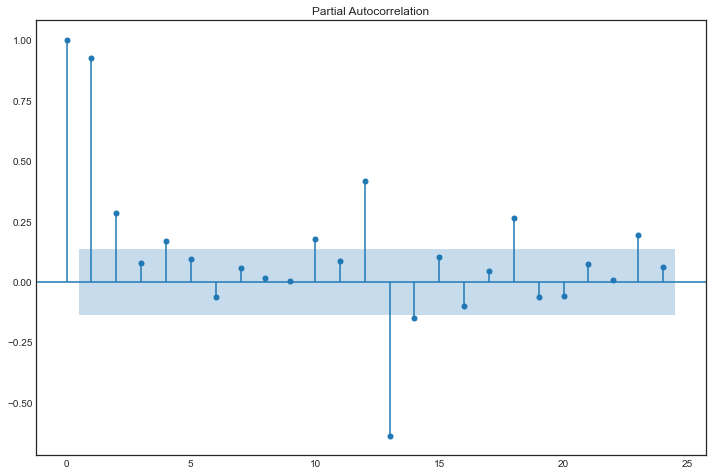

In [19]:
# Plot the PACF
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
plot_pacf(data);

In [20]:
# ADF Test for Stationarity augmented dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf = adfuller(data["value"])[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:1.0 , Series is Non-Stationary


p value:0.00018133843740901883 , Series is Stationary


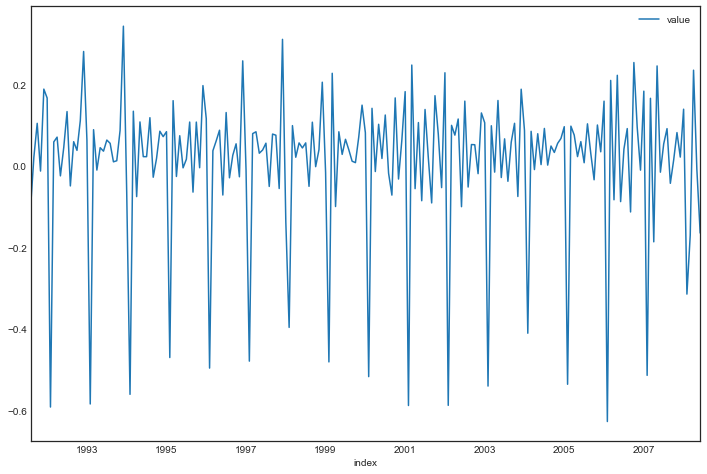

In [21]:
#Try De-trending the series by applying the first difference to the log(data)
# Q: What would happen if you didn't take the log?
ldata =  np.log(data)
de_trended = ldata.diff(1).dropna()
adf2 = adfuller(de_trended)[1]
print(f"p value:{adf2}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")
de_trended.plot();
# Still not stationary

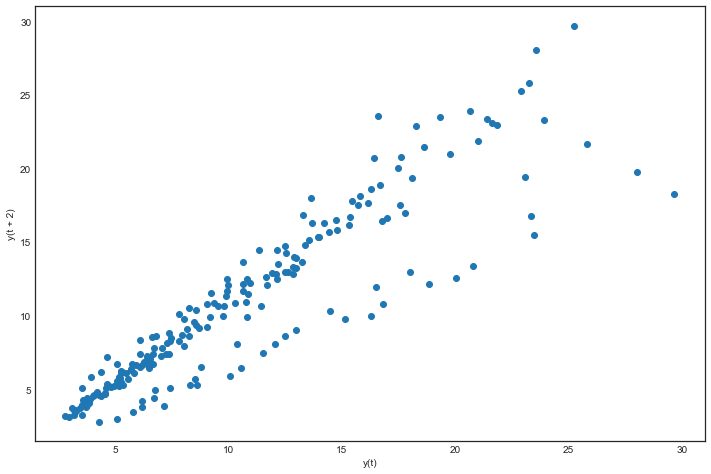

In [22]:
# Plot y_{t-k} vs y_{t}
pd.plotting.lag_plot(data["value"],2);

# Note: You can also use
#sns.scatterplot(data["value"], data["value"].shift(-2));

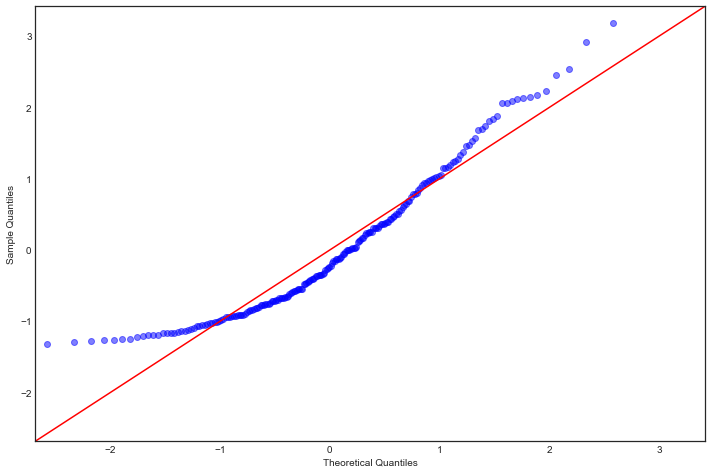

In [23]:
# QQ plot
import statsmodels.api as sm
sm.qqplot(data["value"], fit=True, line='45', alpha=0.5, dist='norm' );

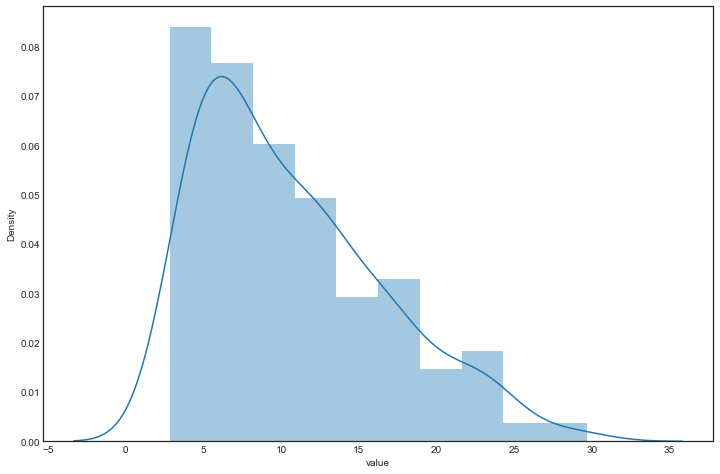

In [24]:
sns.distplot(data["value"]);

In [25]:
#Jarque Bera Test for Normality
from scipy.stats import jarque_bera as jb
is_norm=jb(data["value"])[1]
print(f"p value:{is_norm.round(4)}", ", Series is Normal" if is_norm >0.05 else ", Series is Non-Normal")

p value:0.0 , Series is Non-Normal


In [26]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#import altair as alt
#plt.style.use('seaborn-white')
#%matplotlib inline

#fig, ax = plt.subplots(figsize = (12,8))
#sns.boxplot(data=data, x=data.index, y = 'value',  ax = ax, boxprops=dict(alpha=.3));
#sns.swarmplot(data=data, x=data.index.year, y = 'value');

For a short Python example of basic time series computations, like the two below, see the post on [machine learning+](https://www.machinelearningplus.com/time-series/time-series-analysis-python/) by S. Prabhakaran.  

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

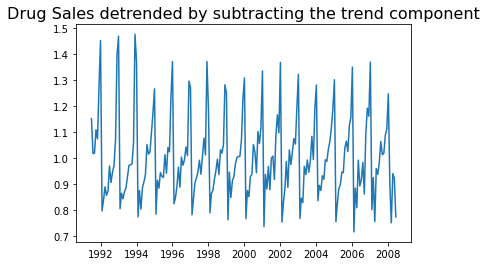

In [5]:
# Detrend the series -subtract the trend

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import matplotlib.pyplot as plt
df = pd.read_csv('a10.csv', parse_dates=True, index_col='index')
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
detrended = df.value.values / result_mul.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)

[]

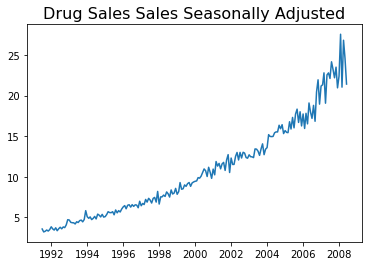

In [6]:
# Seasonally adjust the series (since its multiplicative, we devide. If additive, we substract)
deseasonalized = df.value.values / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Drug Sales Sales Seasonally Adjusted', fontsize=16)
plt.plot()

[]

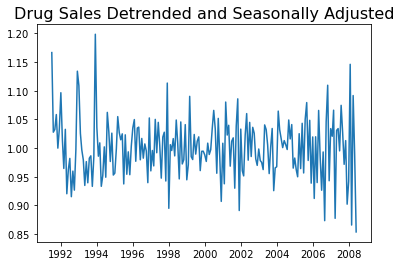

In [7]:
# Detrended and Seasonally adjust the series
innovations = deseasonalized/result_mul.trend
plt.plot(innovations)
plt.title('Drug Sales Detrended and Seasonally Adjusted', fontsize=16)
plt.plot()